### With image task_3_image_2.png

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to image
image = cv2.imread("task_3_image_2.png")

def remove_black_borders(image):
    """
    Removes black borders around the Petri dish image by detecting contours.

    Args:
        image (numpy array): Input raw image.

    Returns:
        numpy array: Cropped image without black borders.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return image[y:y + h, x:x + w]


In [5]:
def create_polygon_mask(shape):
    """
    Creates a polygon mask to isolate the region of interest.

    Args:
        shape (tuple): Shape of the image (height, width).

    Returns:
        numpy array: Mask with the polygon applied.
    """
    mask = np.zeros(shape, dtype="uint8")
    h, w = shape
    points = np.array([
        [int(0.2 * w), int(0.01 * h)],
        [int(0.8 * w), int(0.01 * h)],
        [int(0.94 * w), int(0.06 * h)],
        [int(0.99 * w), int(0.2 * h)],
        [int(0.99 * w), int(0.8 * h)],
        [int(0.94 * w), int(0.94 * h)],
        [int(0.8 * w), int(0.99 * h)],
        [int(0.2 * w), int(0.99 * h)],
        [int(0.06 * w), int(0.94 * h)],
        [int(0.01 * w), int(0.8 * h)],
        [int(0.01 * w), int(0.2 * h)],
        [int(0.06 * w), int(0.06 * h)]
    ], dtype=np.int32)
    cv2.fillConvexPoly(mask, points, 255)
    return mask

def process_image(image_path):
    """
    Processes an input image to perform instance segmentation.

    Args:
        image_path (str): Path to the input image.

    Returns:
        None: Displays the intermediate and final results.
    """
    image = cv2.imread(image_path)

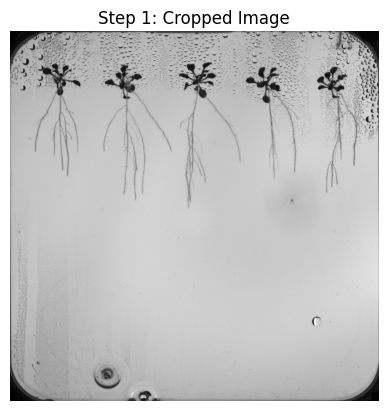

In [6]:
# Step 1: Crop the Petri dish
cropped = remove_black_borders(image)
plt.figure()
plt.title("Step 1: Cropped Image")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

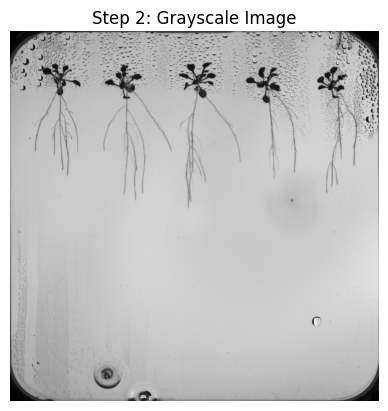

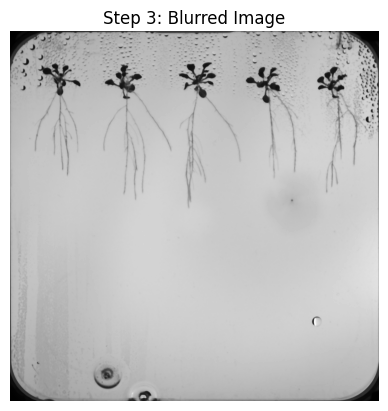

In [7]:
# Step 2: Convert to grayscale and blur
grayscale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.title("Step 2: Grayscale Image")
plt.imshow(grayscale, cmap="gray")
plt.axis("off")
plt.show()

blurred = cv2.medianBlur(grayscale, 11)
plt.figure()
plt.title("Step 3: Blurred Image")
plt.imshow(blurred, cmap="gray")
plt.axis("off")
plt.show()

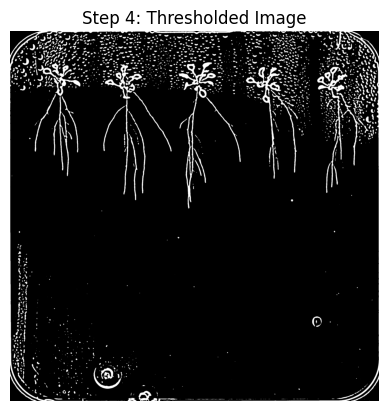

In [8]:
# Step 3: Adaptive thresholding
thresholded = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 5
)
plt.figure()
plt.title("Step 4: Thresholded Image")
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.show()

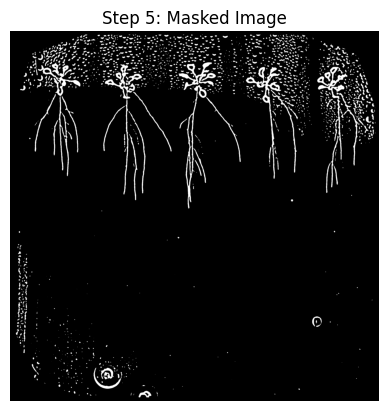

In [9]:
# Step 4: Apply polygon mask
mask = create_polygon_mask(thresholded.shape)
masked_image = cv2.bitwise_and(thresholded, mask)
plt.figure()
plt.title("Step 5: Masked Image")
plt.imshow(masked_image, cmap="gray")
plt.axis("off")
plt.show()

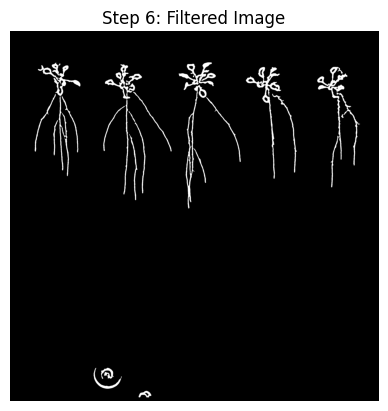

In [10]:
# Step 5: Remove small objects
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(masked_image)
min_size = 1800
filtered_image = np.zeros_like(masked_image)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        filtered_image[labels == i] = 255
plt.figure()
plt.title("Step 6: Filtered Image")
plt.imshow(filtered_image, cmap="gray")
plt.axis("off")
plt.show()


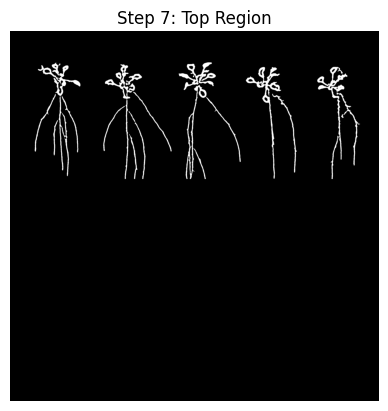

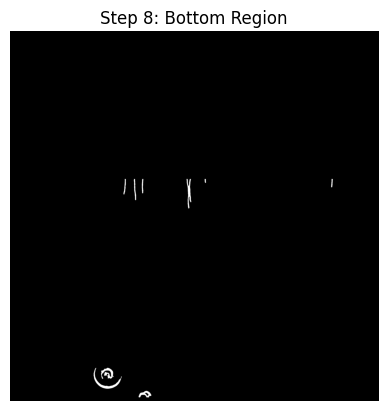

In [11]:
# Step 6: Segment top and bottom regions
h, w = filtered_image.shape
bottom_mask = np.zeros_like(filtered_image)
bottom_mask[int(0.4 * h):, :] = 255
top_region = cv2.bitwise_and(filtered_image, cv2.bitwise_not(bottom_mask))
bottom_region = cv2.bitwise_and(filtered_image, bottom_mask)

plt.figure()
plt.title("Step 7: Top Region")
plt.imshow(top_region, cmap="gray")
plt.axis("off")
plt.show()

plt.figure()
plt.title("Step 8: Bottom Region")
plt.imshow(bottom_region, cmap="gray")
plt.axis("off")
plt.show()

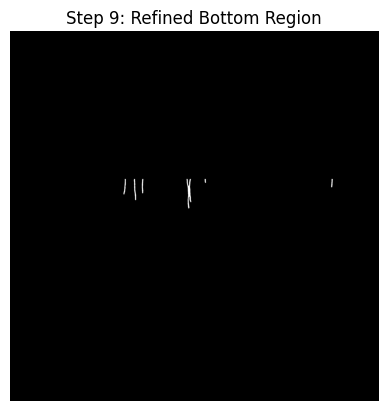

In [12]:
# Step 7: Process bottom region
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bottom_region)
refined_bottom = np.zeros_like(bottom_region)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
    if area < 50000 and h / w > 1.2:
        refined_bottom[labels == i] = 255

plt.figure()
plt.title("Step 9: Refined Bottom Region")
plt.imshow(refined_bottom, cmap="gray")
plt.axis("off")
plt.show()

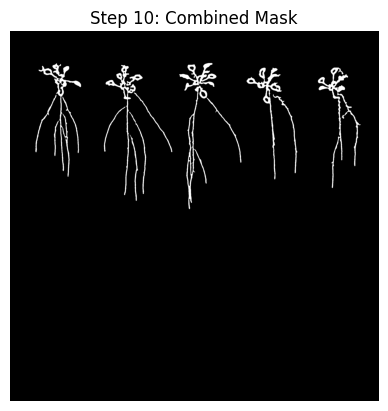

In [13]:
# Step 8: Combine regions and refine
combined = cv2.bitwise_or(top_region, refined_bottom)
kernel = np.ones((2, 2), dtype="uint8")
final_mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=5)

plt.figure()
plt.title("Step 10: Combined Mask")
plt.imshow(final_mask, cmap="gray")
plt.axis("off")
plt.show()

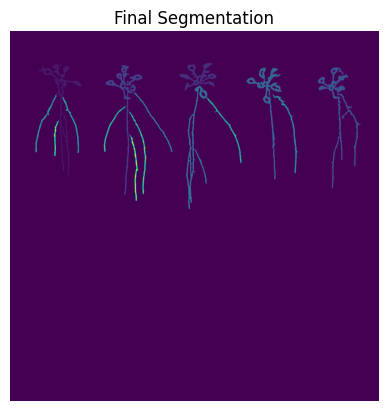

In [14]:
# Step 9: Display final result
num_labels, labels, _, _ = cv2.connectedComponentsWithStats(final_mask)
plt.figure()
plt.title("Final Segmentation")
plt.imshow(labels, cmap="viridis")
plt.axis("off")
plt.show()

# Path to image
process_image("task_3_image_2.png")

### With image task_3_image_1.png

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to image
image = cv2.imread("task_3_image_1.png")

def remove_black_borders(image):
    """
    Removes black borders around the Petri dish image by detecting contours.

    Args:
        image (numpy array): Input raw image.

    Returns:
        numpy array: Cropped image without black borders.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return image[y:y + h, x:x + w]

In [16]:
def create_polygon_mask(shape):
    """
    Creates a polygon mask to isolate the region of interest.

    Args:
        shape (tuple): Shape of the image (height, width).

    Returns:
        numpy array: Mask with the polygon applied.
    """
    mask = np.zeros(shape, dtype="uint8")
    h, w = shape
    points = np.array([
        [int(0.2 * w), int(0.01 * h)],
        [int(0.8 * w), int(0.01 * h)],
        [int(0.94 * w), int(0.06 * h)],
        [int(0.99 * w), int(0.2 * h)],
        [int(0.99 * w), int(0.8 * h)],
        [int(0.94 * w), int(0.94 * h)],
        [int(0.8 * w), int(0.99 * h)],
        [int(0.2 * w), int(0.99 * h)],
        [int(0.06 * w), int(0.94 * h)],
        [int(0.01 * w), int(0.8 * h)],
        [int(0.01 * w), int(0.2 * h)],
        [int(0.06 * w), int(0.06 * h)]
    ], dtype=np.int32)
    cv2.fillConvexPoly(mask, points, 255)
    return mask

def process_image(image_path):
    """
    Processes an input image to perform instance segmentation.

    Args:
        image_path (str): Path to the input image.

    Returns:
        None: Displays the intermediate and final results.
    """
    image = cv2.imread(image_path)

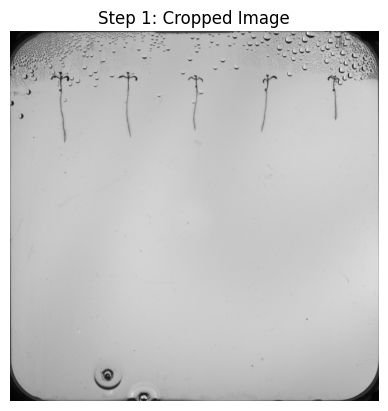

In [17]:
# Step 1: Crop the Petri dish
cropped = remove_black_borders(image)
plt.figure()
plt.title("Step 1: Cropped Image")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

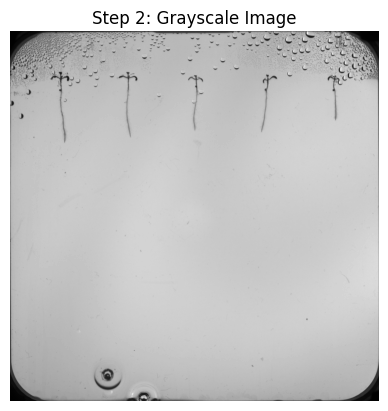

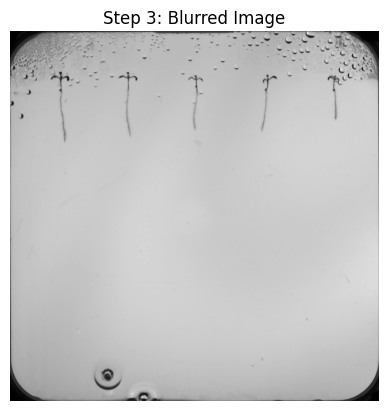

In [18]:
# Step 2: Convert to grayscale and blur
grayscale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.title("Step 2: Grayscale Image")
plt.imshow(grayscale, cmap="gray")
plt.axis("off")
plt.show()

blurred = cv2.medianBlur(grayscale, 11)
plt.figure()
plt.title("Step 3: Blurred Image")
plt.imshow(blurred, cmap="gray")
plt.axis("off")
plt.show()

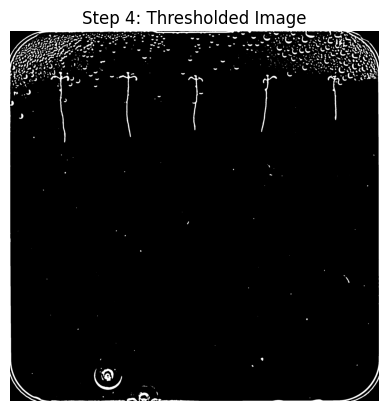

In [19]:
# Step 3: Adaptive thresholding
thresholded = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 5
)
plt.figure()
plt.title("Step 4: Thresholded Image")
plt.imshow(thresholded, cmap="gray")
plt.axis("off")
plt.show()

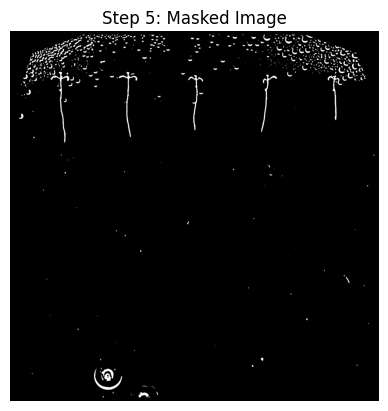

In [20]:
# Step 4: Apply polygon mask
mask = create_polygon_mask(thresholded.shape)
masked_image = cv2.bitwise_and(thresholded, mask)
plt.figure()
plt.title("Step 5: Masked Image")
plt.imshow(masked_image, cmap="gray")
plt.axis("off")
plt.show()

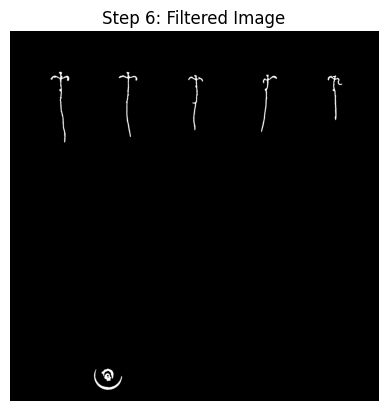

In [21]:
# Step 5: Remove small objects
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(masked_image)
min_size = 1800
filtered_image = np.zeros_like(masked_image)
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        filtered_image[labels == i] = 255
plt.figure()
plt.title("Step 6: Filtered Image")
plt.imshow(filtered_image, cmap="gray")
plt.axis("off")
plt.show()

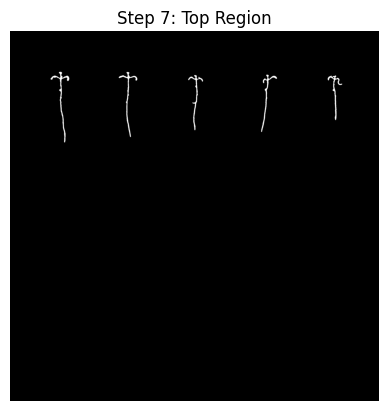

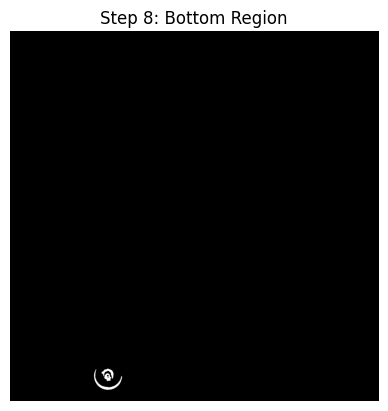

In [22]:
# Step 6: Segment top and bottom regions
h, w = filtered_image.shape
bottom_mask = np.zeros_like(filtered_image)
bottom_mask[int(0.4 * h):, :] = 255
top_region = cv2.bitwise_and(filtered_image, cv2.bitwise_not(bottom_mask))
bottom_region = cv2.bitwise_and(filtered_image, bottom_mask)

plt.figure()
plt.title("Step 7: Top Region")
plt.imshow(top_region, cmap="gray")
plt.axis("off")
plt.show()

plt.figure()
plt.title("Step 8: Bottom Region")
plt.imshow(bottom_region, cmap="gray")
plt.axis("off")
plt.show()

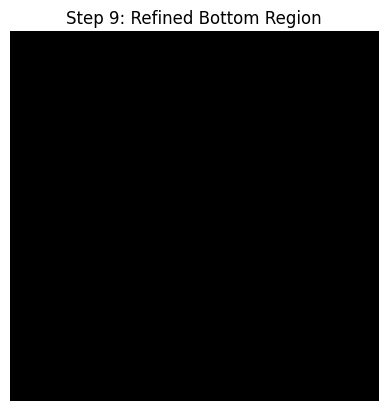

In [23]:
# Step 7: Process bottom region
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bottom_region)
refined_bottom = np.zeros_like(bottom_region)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
    if area < 50000 and h / w > 1.2:
        refined_bottom[labels == i] = 255

plt.figure()
plt.title("Step 9: Refined Bottom Region")
plt.imshow(refined_bottom, cmap="gray")
plt.axis("off")
plt.show()

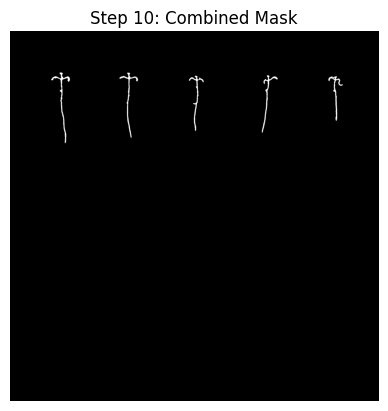

In [24]:
# Step 8: Combine regions and refine
combined = cv2.bitwise_or(top_region, refined_bottom)
kernel = np.ones((2, 2), dtype="uint8")
final_mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=5)

plt.figure()
plt.title("Step 10: Combined Mask")
plt.imshow(final_mask, cmap="gray")
plt.axis("off")
plt.show()

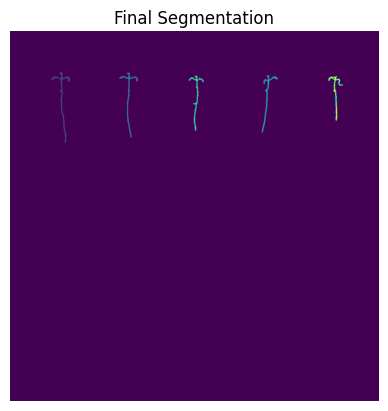

In [25]:
# Step 9: Display final result
num_labels, labels, _, _ = cv2.connectedComponentsWithStats(final_mask)
plt.figure()
plt.title("Final Segmentation")
plt.imshow(labels, cmap="viridis")
plt.axis("off")
plt.show()

# Path to image
process_image("task_3_image_2.png")